In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL
import PIL.Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from pathlib import Path

In [2]:
data = Path(r"D:\D.L CV\flower_photos")
if not data.exists():
    (f"Directory{data}does not exist!")
else:
    image_count = len(list(data.glob('*/*.jpg')))
    if image_count == 0:
        image_count = len(list(data.glob('*/*.jpeg')))
    if image_count == 0:
        image_count = len(list(data.glob('*/*.png')))
    (f"Total number of images:{image_count}")

In [3]:
roses = list(data.glob('roses/*'))
image_path = roses[0]
img = PIL.Image.open(str(image_path))
img.show()

In [4]:
tflower = list(data.glob('tulips/*'))
image_path = tflower[0]
img = PIL.Image.open(str(image_path))
img.show()

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

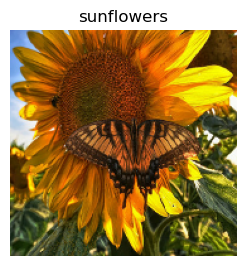

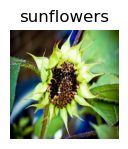

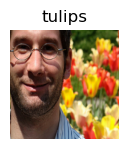

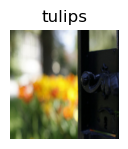

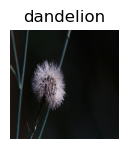

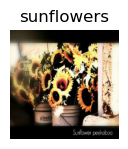

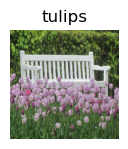

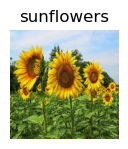

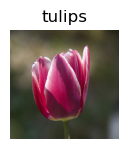

In [11]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.show()

In [12]:
for image_batch,labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch,labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
(np.min(first_image),np.max(first_image))

(0.0, 0.99778503)

In [16]:
num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255,input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])

C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 346ms/step - accuracy: 0.3282 - loss: 1.8511 - val_accuracy: 0.5150 - val_loss: 1.1416
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 313ms/step - accuracy: 0.5503 - loss: 1.0837 - val_accuracy: 0.6090 - val_loss: 0.9817
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 310ms/step - accuracy: 0.6493 - loss: 0.8899 - val_accuracy: 0.6322 - val_loss: 0.9620
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 312ms/step - accuracy: 0.7286 - loss: 0.7247 - val_accuracy: 0.6717 - val_loss: 0.9123
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 313ms/step - accuracy: 0.7966 - loss: 0.5674 - val_accuracy: 0.6172 - val_loss: 1.0638
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 314ms/step - accuracy: 0.8784 - loss: 0.3683 - val_accuracy: 0.6635 - val_loss: 1.1273
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 315ms/step - accuracy: 0.9462 - loss: 0.1866 - val_accuracy: 0.6294 - val_loss: 1.3486
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 313ms/step - accuracy: 0.9634 - loss: 0.1195 - val_accu

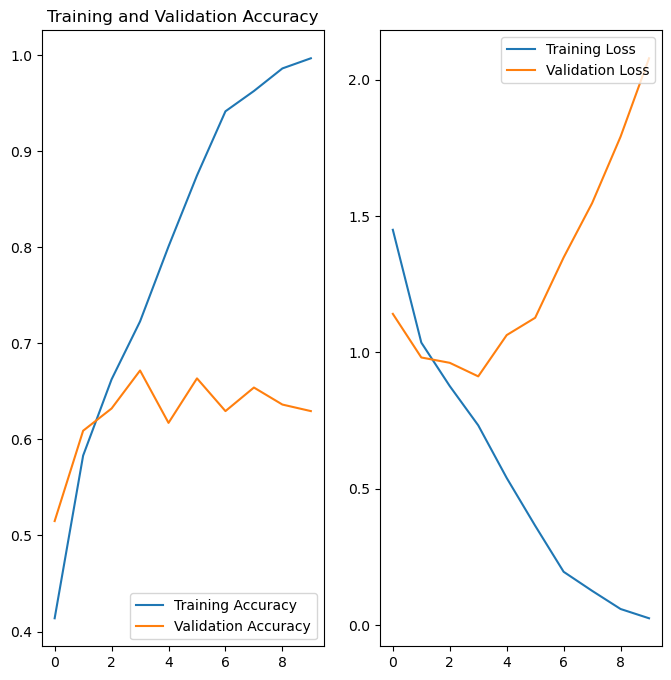

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [24]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                       input_shape=(img_height,
                                    img_width,3)),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.1),
    ]
)

C:\Users\dell\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_11. Received: the structure of inputs=('*', '*')
  warnings.warn(


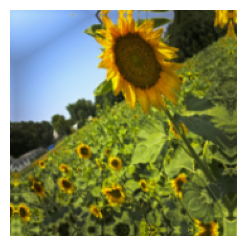

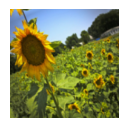

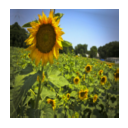

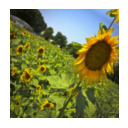

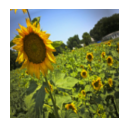

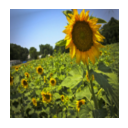

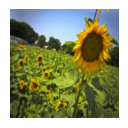

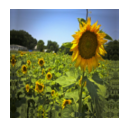

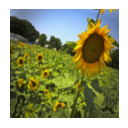

In [28]:
plt.figure(figsize=(10,10))
for images in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
        plt.show()

In [29]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes,name="outputs")
])

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 445ms/step - accuracy: 0.3642 - loss: 1.4069 - val_accuracy: 0.5545 - val_loss: 1.0647
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 447ms/step - accuracy: 0.5609 - loss: 1.0664 - val_accuracy: 0.6267 - val_loss: 0.9922
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 385ms/step - accuracy: 0.6515 - loss: 0.9379 - val_accuracy: 0.6431 - val_loss: 0.9217
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 288ms/step - accuracy: 0.6425 - loss: 0.9015 - val_accuracy: 0.6267 - val_loss: 0.9372
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 295ms/step - accuracy: 0.6492 - loss: 0.8737 - val_accuracy: 0.6594 - val_loss: 0.8400
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 295ms/step - accuracy: 0.7033 - loss: 0.7833 - val_accuracy: 0.7016 - val_loss: 0.7739
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.7076 - loss: 0.7286 - val_accuracy: 0.6880 - val_loss: 0.8016
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - accuracy: 0.7289 - loss: 0.7000 - val_accu

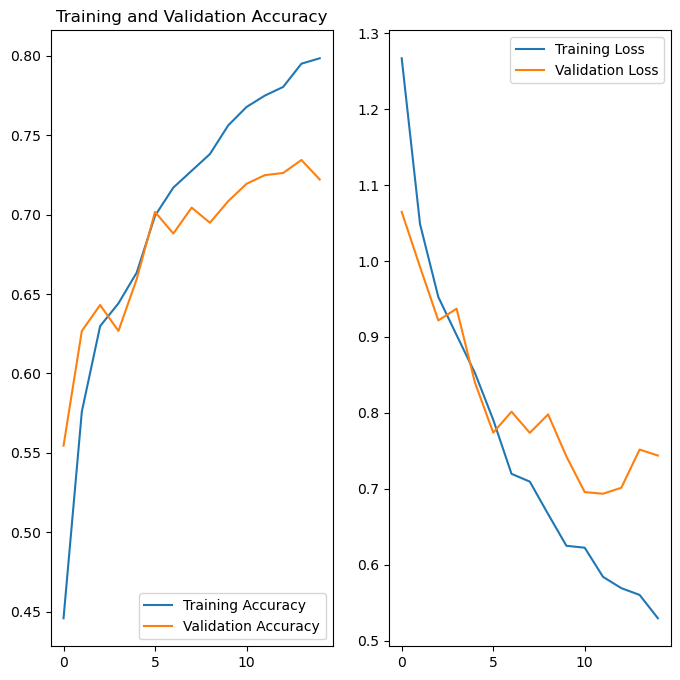

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [45]:
sunflower_path = Path(r"D:\D.L CV\usha-kiran-Lw0qPaLIgdA-unsplash.jpg")

img = tf.keras.utils.load_img(
    sunflower_path,target_size = (img_height,img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array,0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

("This image most likely belongs to {} with a {:.2f} percent confidence."
 .format(class_names[np.argmax(score)],100*np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'This image most likely belongs to roses with a 83.23 percent confidence.'